# Модель 22 (GoogLeNet)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Импорт необходимых библиотек

In [ ]:
!pip install tensorflow-addons
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd drive/MyDrive/YaMlProject/models/models

/content/drive/MyDrive/YaMlProject/models/models


In [ ]:
import sys
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import torchvision as tv
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
from livelossplot import PlotLossesKeras

sys.path.append('../../')

from core.datasets import get_ds
from core.make_answer import make_ans_file

c:\Users\Mi\Desktop\ML\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_model = '_g_22'

#### Аугментация (4)

In [ ]:
transformer = tv.transforms.Compose([
    tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5),
    tv.transforms.RandomAffine(degrees=(-10, 10), translate=(0, 0.1), scale=(0.85, 1)),
    tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.7),
])

#### Скачиваем датасеты

In [ ]:
train_ds, val_ds, test_ds = get_ds(
    'smote_data_train_7000', 'repaired_data_test',
    transform=transformer, one_hot=True, back=2, batch_size=100
)

Для дальнейшей проверки метрик разделяем валидационный датасет на x и y

In [ ]:
val_ds_x = np.array([i[0] for i in val_ds.unbatch().as_numpy_iterator()])
val_ds_y = np.array([i[1] for i in val_ds.unbatch().as_numpy_iterator()])

Смотрим на получившуюся агументацию.

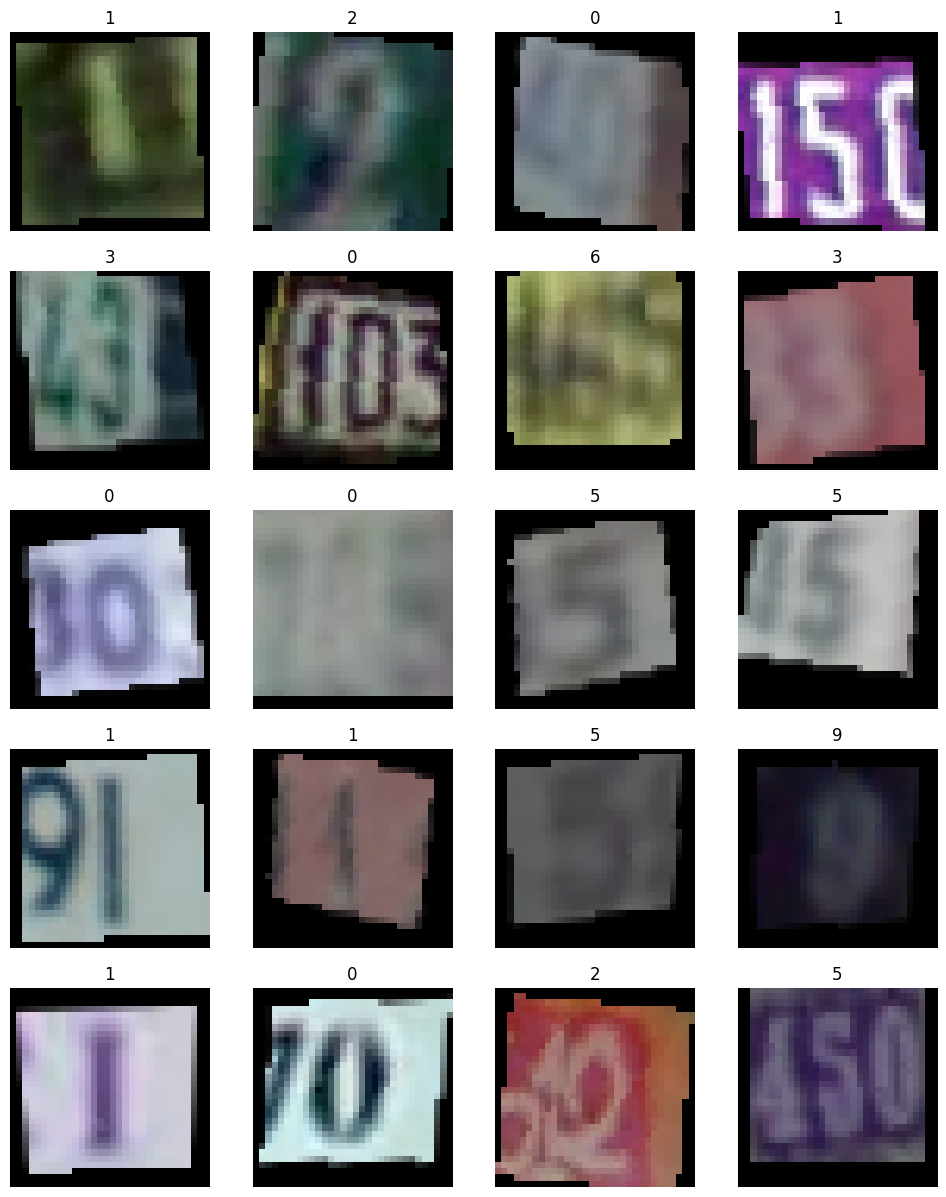

In [ ]:
plt.figure(figsize=(12, 15))
train_ds_visualization = train_ds[0]
for i in range(20):
    plt.subplot(5, 4, i + 1)
    img = np.array(Image.fromarray((train_ds_visualization[0][i] * 255).astype(np.uint8), 'RGB'))
    plt.imshow(img / 255, cmap=plt.cm.binary)
    plt.title(np.argmax(train_ds_visualization[1][i]))
    plt.axis('off')
plt.show()

#### Пишем модель
![-](https://media.geeksforgeeks.org/wp-content/uploads/20200429201549/Inceptionv1_architecture.png)
[![-](https://media.geeksforgeeks.org/wp-content/uploads/20200429201304/Incepption-module.PNG)](https://machinelearningknowledge.ai/googlenet-architecture-implementation-in-keras-with-cifar-10-dataset/) <-- ссылка

In [ ]:
def tree(x, filters, kernel_size, strides=1, padding='same'):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)

In [ ]:
inputs = tf.keras.layers.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, (5, 5), padding='same')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
fork = tf.keras.layers.ReLU()(x)

In [ ]:
tree1 = tree(fork, 16, 1, strides=1)
tree2 = tree(fork, 16, 3, strides=1)
tree3 = tree(fork, 16, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(16, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 32, 1, strides=1)
tree2 = tree(fork, 32, 3, strides=1)
tree3 = tree(fork, 32, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(23, 1, padding='same', activation='relu')(tree4)
fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 32, 32, 119])

In [ ]:
tree1 = tree(fork, 48, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 15, 15, 167])

In [ ]:
tree1 = tree(fork, 48, 1, strides=1)
tree2 = tree(fork, 48, 3, strides=1)
tree3 = tree(fork, 48, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(48, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 64, 1, strides=1)
tree2 = tree(fork, 64, 3, strides=1)
tree3 = tree(fork, 64, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(64, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

fork.shape

TensorShape([None, 15, 15, 256])

In [ ]:
tree1 = tree(fork, 80, 3, 2, padding='valid')
tree2 = tf.keras.layers.MaxPooling2D(3, strides=2)(fork)
fork = tf.keras.layers.concatenate([tree1, tree2])
fork.shape

TensorShape([None, 7, 7, 336])

In [ ]:
tree1 = tree(fork, 80, 1, strides=1)
tree2 = tree(fork, 80, 3, strides=1)
tree3 = tree(fork, 80, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(80, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])

tree1 = tree(fork, 96, 1, strides=1)
tree2 = tree(fork, 96, 3, strides=1)
tree3 = tree(fork, 96, 5, strides=1)
tree4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(fork)
tree4 = tf.keras.layers.Conv2D(96, 1, padding='same', activation='relu')(tree4)

fork = tf.keras.layers.concatenate([tree1, tree2, tree3, tree4])
fork.shape

TensorShape([None, 7, 7, 384])

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(fork)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(10)(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_54 (Conv2D)             (None, 32, 32, 32)   2432        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_42 (BatchN  (None, 32, 32, 32)  128         ['conv2d_54[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_42 (ReLU)                (None, 32, 32, 32)   0           ['batch_normalization_42[0]

#### Создаем чекпоинты

In [10]:
metrics = ['categorical_accuracy',
           tfa.metrics.F1Score(num_classes=10, average='macro', name='f1_score')]
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=f'../checkpoints/model{num_model}_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    ),

    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_categorical_accuracy.h5',
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_loss.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
    ),
    tfa.callbacks.AverageModelCheckpoint(
        update_weights=False,
        filepath=f'../checkpoints/model{num_model}_avg_f1_score.h5',
        monitor='val_f1_score',
        mode='max',
        save_best_only=True,
    )
]

NameError: ignored

#### Компиляция модели

In [9]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    return lr * tf.math.exp(-0.008)


callbacks.append(tf.keras.callbacks.LearningRateScheduler(scheduler))

NameError: ignored

In [ ]:
model.compile(
    optimizer=tfa.optimizers.MovingAverage(tf.keras.optimizers.legacy.Adam(0.0013, decay=0.002)),
    metrics=metrics,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
)

#### Обучаем модель

In [ ]:
history = model.fit(train_ds, validation_data=val_ds,
          epochs=100, callbacks=callbacks, verbose=1)

Epoch 1/100
651/651 [==============================] - 167s 162ms/step - loss: 0.8946 - categorical_accuracy: 0.6957 - f1_score: 0.6954 - val_loss: 0.5987 - val_categorical_accuracy: 0.8155 - val_f1_score: 0.8200 - lr: 0.0016
Epoch 2/100
651/651 [==============================] - 105s 161ms/step - loss: 0.3155 - categorical_accuracy: 0.9039 - f1_score: 0.9039 - val_loss: 0.5028 - val_categorical_accuracy: 0.8494 - val_f1_score: 0.8586 - lr: 0.0016
Epoch 3/100
651/651 [==============================] - 103s 159ms/step - loss: 0.2596 - categorical_accuracy: 0.9234 - f1_score: 0.9234 - val_loss: 0.2797 - val_categorical_accuracy: 0.9243 - val_f1_score: 0.9243 - lr: 0.0016
Epoch 4/100
651/651 [==============================] - 105s 162ms/step - loss: 0.2313 - categorical_accuracy: 0.9304 - f1_score: 0.9304 - val_loss: 0.2453 - val_categorical_accuracy: 0.9331 - val_f1_score: 0.9335 - lr: 0.0016
Epoch 5/100
651/651 [==============================] - 97s 148ms/step - loss: 0.2098 - categoric

# ВЫВОД:

Модель является улучшенной версией googlenet подобной модели. Является одной из лучших.